# WhatsApp Chat Analysis

In [1]:
# Import modules and libriaries
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import re 
import datetime as dt 
from urlextract import URLExtract # used to extract url's in a string
from collections import Counter
from wordcloud import WordCloud
import string 
import nltk
import emoji


pd.set_option('display.max_colwidth', 100)

stopwords = nltk.corpus.stopwords.words("english")
wn = nltk.WordNetLemmatizer()
punct = string.punctuation

%matplotlib inline

## Data (text) Preprocessing

### Import Text Data

We will now import the text file which contains the whatsapp group chat in read mode using utf-8 encoding.

In [2]:
def rawToDf(file, key):
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%m/%d/%y, %I:%M %p - ',
        '24hr' : '%m/%d/%y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding="utf8") as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'Date': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['Date'] = pd.to_datetime(df['Date'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("Group Notification")
            msgs.append(a[0])

    # creating new columns         
    df['User'] = usernames
    df['Message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    df = df[["Message", "Date", "User"]]
    
    df["Message"] = df["Message"].apply(lambda x: x.strip())
    
    # Extract the date without time
    df['Only date'] = pd.to_datetime(df['Date']).dt.date

    # Get only the Year
    df['Year'] = pd.to_datetime(df['Date']).dt.year

    # Get month number
    df['Month_num'] = pd.to_datetime(df['Date']).dt.month

    # Get name of month
    df['Month'] = pd.to_datetime(df['Date']).dt.month_name()

    # Get Day
    df['Day'] = pd.to_datetime(df['Date']).dt.day

    # Get name of Day
    df['Day_name'] = pd.to_datetime(df['Date']).dt.day_name()

    # Get hour
    df['Hour'] = pd.to_datetime(df['Date']).dt.hour

    # Get minutes
    df['Minute'] = pd.to_datetime(df['Date']).dt.minute

    
    
    return df

In [3]:
df = rawToDf("whatsapp_chat_automobile.txt", "12hr")
df.head()

,Message,Date,User,Only date,Year,Month_num,Month,Day,Day_name,Hour,Minute
0,"Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can...",2023-01-14 10:18:00,Group Notification,2023-01-14,2023,1,January,14,Saturday,10,18
1,"Camry White created group ""M I AUTOS ABUJA""",2022-09-21 08:34:00,Group Notification,2022-09-21,2022,9,September,21,Wednesday,8,34
2,Camry White added you,2023-01-14 10:18:00,Group Notification,2023-01-14,2023,1,January,14,Saturday,10,18
3,The message timer was updated. New messages will disappear from this chat 7 days after they're s...,2023-01-14 10:18:00,Group Notification,2023-01-14,2023,1,January,14,Saturday,10,18
4,Camry White added +234 806 709 4011,2023-01-14 10:27:00,Group Notification,2023-01-14,2023,1,January,14,Saturday,10,27


In [4]:
# # import text data
# f = open("whatsapp_chat_data.txt", "r", encoding="utf-8")

# data = f.read()

In [5]:
# dummy = data.split("\n")
# dummy

### Separate messages and date/time
We want to ensure that every text entry has a date and time stamp in the specified example below:

Example for dry run : `'16/08/18, 20:09 - '`

\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s

- the first part "d{1,2}" this means here we can have one or 2 digits
- then after we have "/"
- then after we have "d{1,2}" again,same we can have one or 2 digits
- then after we have "/"
- then after we have "d{2,4}" here we check for 2 or more digits
- then a ","
- then we have a space represented as "\s"
- then we have hour representation it can take either one or 2 digits 
- then we have a seperator ":" 

and the pattern repeats so on..

In [6]:
# # regex pattern to track date and time
# pattern = '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s'

# # Extract only the messages
# messages = re.split(pattern, data)[1:]
# print(len(messages))

# # Extracting only the date/time
# dates = re.findall(pattern, data)
# print(len(dates))

**Sample illustration**

In [7]:
# # regex pattern to track date and time
# pattern = '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s'

# text_data =  '8/25/22, 04:08 - Segun Lawal: Hello, please this video stopped playing at the 2:45 timestamp, only the audio was running'

In [8]:
# # Extract message
# re.split(pattern, text_data)[1]

In [9]:
# # Extracting only the dates
# re.findall(pattern, text_data)[0]

In [10]:
# messages[:5]

In [11]:
# dates[:5]

This is  a simple time string, we will apply the following transformation in order to get the date and the time for our analysis

In [12]:
# string = "8/26/22, 20:09 - "
# string

In [13]:
# string = string.split(',')
# string

In [14]:
# date,time = string[0],string[1]
# date,time

In [15]:
# time = time.split('-')
# time = time[0].strip() # remove white spaces
# time

In [16]:
# print(date+ " and "+ time)

### Separate date and time
We will create a function that separates the time from the date

In [17]:
# # This function separetes the time from the date
# def get_date_and_time(string):
#     string = string.split(",")
#     date, time = string[0], string[1]
#     time = time.split("-")
#     time = time[0].strip()
    
#     return date+" "+time 

### Create a dataframe for messages and their corresponding time

Now we have separated the messages and the time, let's create a dataframe with two columns for messages and date/time.

In [18]:
# df = pd.DataFrame({"user_messages": messages, 
#                    "message_date": dates})

# # Apply the function that separates the time from the date
# df["message_date"] = df["message_date"].apply(lambda text: get_date_and_time(text))

# df.head()

In [19]:
# # Let's rename the "message_date" solumn to "date"
# df.rename(columns={"message_date": "date"}, inplace=True)

# df.head()

In [20]:
# df["user_messages"]

### Separating users name/numbers from users message
If we observe the `user_messages` column, we find that the users name/number is attached with the user message. Therefore we need to get rid of this. For that we will use the concept of regular expression to separate the users name/number from the users message

**Sample illustration**

In [21]:
# import random
# txt = df["user_messages"][random.randrange(0, len(df["user_messages"]))]
# txt

In [22]:
# re.split('([\w\W]+?):\s', txt)

In [23]:
# # Separate users number/name from users message
# users = []
# messages = []

# # loop through the "user_messages" column
# for message in df["user_messages"]:
    
#     # Split on the regex expression match."users name or number"
#     entry = re.split('([\w\W]+?):\s', message)
    
#     # very this message has a name/number
#     if entry[1:]:
#         users.append(entry[1])
#         messages.append(entry[2])
        
#     # else it is a "Group Notification"
#     else:
#         users.append("Group Notification")
#         messages.append(entry[0])

# # add the users and messages to new columns in he dataframe      
# df["User"] = users
# df["message"] = messages

# # remove the traling "\n" and the end of each message
# def get_string(text):
#     return text.split("\n")[0]

# df["message"] = df["message"].apply(lambda text: get_string(text))

# df.head()

In [24]:
# # Drop and rename columns
# df = df.drop(columns=["user_messages"])
# df = df[["message", "date", "User"]]
# df = df.rename(columns={"message": "Message", 
#                    "date": "Date"})
# df.head()

In [25]:
# df.head()

In [26]:
# # get the shape of the dataframe
# df.shape

### Breaking Down the "Date" Column

Our dates are in the format

`8/22/22 19:06`

Which represents:
    
`MM-DD-YY`

However, `pd.to_datetime()` will convert it to this format

`YY-MM-DD`

In [27]:
# # Extract the date without time
# df['Only date'] = pd.to_datetime(df['Date']).dt.date

# # Get only the Year
# df['Year'] = pd.to_datetime(df['Date']).dt.year

# # Get month number
# df['Month_num'] = pd.to_datetime(df['Date']).dt.month

# # Get name of month
# df['Month'] = pd.to_datetime(df['Date']).dt.month_name()

# # Get Day
# df['Day'] = pd.to_datetime(df['Date']).dt.day

# # Get name of Day
# df['Day_name'] = pd.to_datetime(df['Date']).dt.day_name()

# # Get hour
# df['Hour'] = pd.to_datetime(df['Date']).dt.hour

# # Get minutes
# df['Minute'] = pd.to_datetime(df['Date']).dt.minute

# # View dataframe head
# df.head()

We have successfully completed the `Text Preprocessing`. We will not proceed to `Text Analysis`


## Data (Text) Analysis

### Numerical Analysiy

**Total number of messages in the group**

In [28]:
# Get total number of messsages in the group
len(df["Message"])

18835

**Total number of words in the group**

In [29]:
# Total number of words in the group chat
words = []
for message in df["Message"]:
    words.extend(message.split())
    
print(len(words))

106705


**Total number of media files shared in the group**

In [30]:
df["Message"][18830].strip()

'<Media omitted>'

In [31]:
# Get number of media files shared in the group
len(df[df["Message"] == "<Media omitted>"])

14884

**Total number of links in the group**

In [32]:
# Get number of links in the group
extract = URLExtract()

links = []
for message in df["Message"]:
    links.extend(extract.find_urls(message))
    
len(links)

20

**Most active users**

In [33]:
# discard Group notifications
active_users_df = df[df['User'] != 'Group Notification']
active_users_df.head()

,Message,Date,User,Only date,Year,Month_num,Month,Day,Day_name,Hour,Minute
48,<Media omitted>,2023-02-14 12:33:00,+234 907 879 6039,2023-02-14,2023,2,February,14,Tuesday,12,33
49,Registered but not use Toyota sienna 2007 model available for sale in ijebu ode.... First body p...,2023-02-14 12:33:00,+234 907 879 6039,2023-02-14,2023,2,February,14,Tuesday,12,33
50,<Media omitted>,2023-02-14 12:39:00,Iliyasu,2023-02-14,2023,2,February,14,Tuesday,12,39
51,,2023-02-14 12:44:00,+234 807 344 2908,2023-02-14,2023,2,February,14,Tuesday,12,44
52,<Media omitted>,2023-02-14 12:46:00,+234 803 697 9673,2023-02-14,2023,2,February,14,Tuesday,12,46


In [34]:
# Avtive users and number of messages posted in the group
pd.DataFrame(active_users_df["User"].value_counts()).rename(columns={"User":"posts"})

,posts
+234 708 537 4731,3604
+234 907 879 6039,1662
Iliyasu,1169
+234 706 891 4010,1057
+234 811 352 6684,1020
...,...
+234 803 416 4789,1
+234 908 199 9747,1
+234 802 725 6563,1
+234 803 913 5144,1


In [35]:
# Top 5 active users
top_5_users = active_users_df["User"].value_counts().head()
top_5_users

+234 708 537 4731    3604
+234 907 879 6039    1662
Iliyasu              1169
+234 706 891 4010    1057
+234 811 352 6684    1020
Name: User, dtype: int64

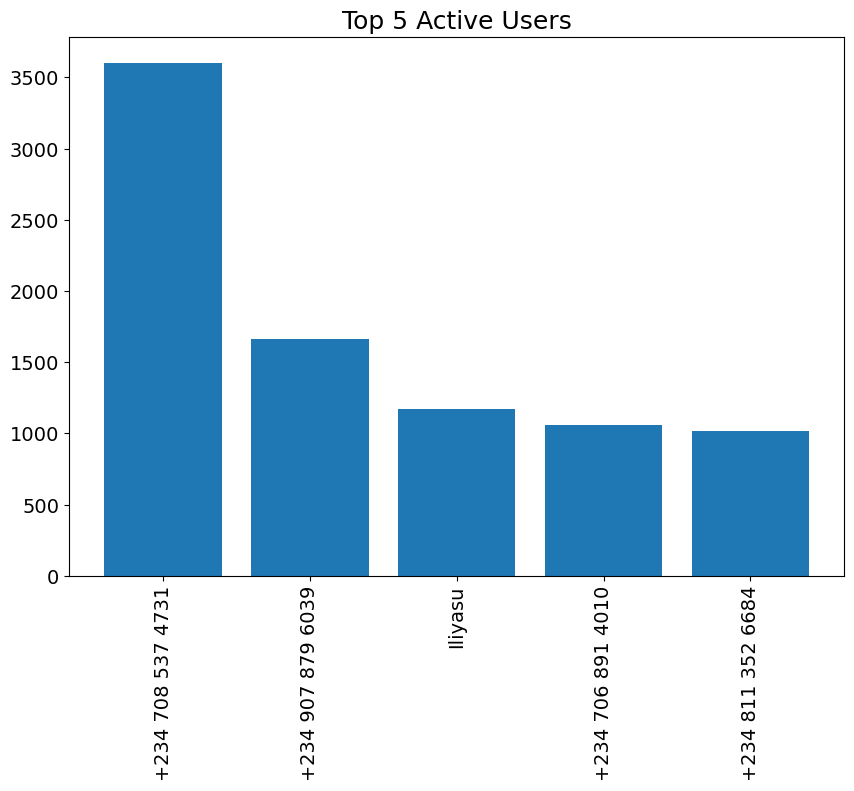

In [36]:
# Plot the bar chat of top 5 active users
plt.figure(figsize=(10, 7))
plt.bar(top_5_users.index, top_5_users.values)
plt.xticks(rotation = 'vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.title("Top 5 Active Users", fontsize=18);

### Word Cloud

In [37]:
# Get dataframe without "<Media omitted>"
wc_df = df[df["Message"] != "<Media omitted>"]
wc_df.head()

,Message,Date,User,Only date,Year,Month_num,Month,Day,Day_name,Hour,Minute
0,"Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can...",2023-01-14 10:18:00,Group Notification,2023-01-14,2023,1,January,14,Saturday,10,18
1,"Camry White created group ""M I AUTOS ABUJA""",2022-09-21 08:34:00,Group Notification,2022-09-21,2022,9,September,21,Wednesday,8,34
2,Camry White added you,2023-01-14 10:18:00,Group Notification,2023-01-14,2023,1,January,14,Saturday,10,18
3,The message timer was updated. New messages will disappear from this chat 7 days after they're s...,2023-01-14 10:18:00,Group Notification,2023-01-14,2023,1,January,14,Saturday,10,18
4,Camry White added +234 806 709 4011,2023-01-14 10:27:00,Group Notification,2023-01-14,2023,1,January,14,Saturday,10,27


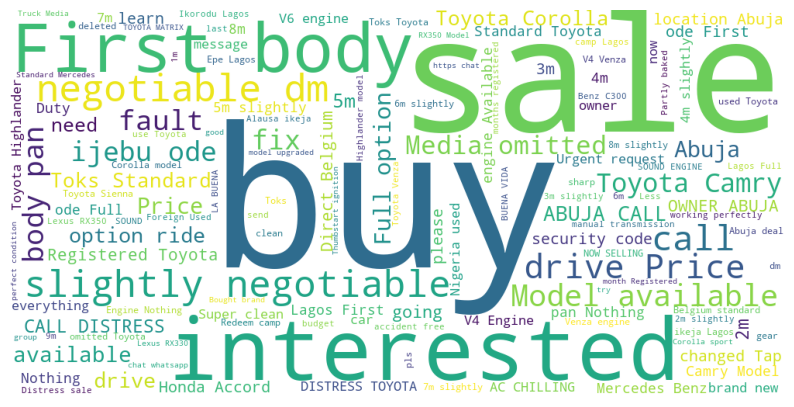

In [38]:
# create word cloud object
wc = WordCloud(width=1000, height=500, min_font_size=10, 
              background_color="white")

# generate wordcloud image
wc = wc.generate(wc_df["Message"].str.cat(sep=" "))

# plot word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wc)
plt.axis("off");

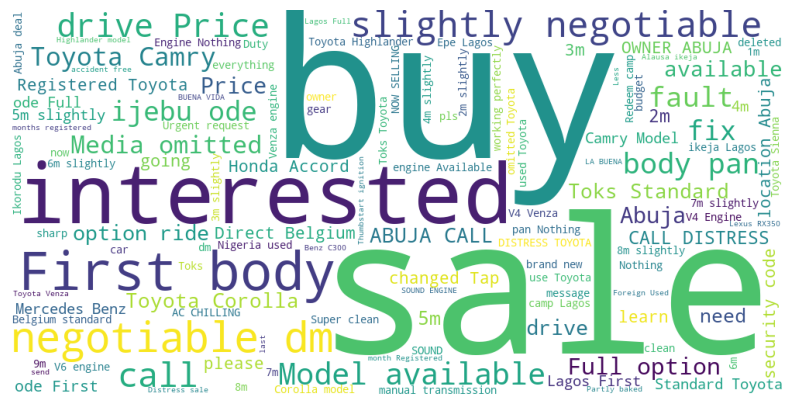

In [39]:
# create word cloud object
wc = WordCloud(width=1000, height=500, min_font_size=10, 
              background_color="white")

# generate wordcloud image
wc = wc.generate(wc_df["Message"].str.cat(sep=" "))

# plot word cloud
fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(wc)
ax.axis("off");

### Most Common Words

In [40]:
# without "<Media omitted>" in meassages column
wc_df

,Message,Date,User,Only date,Year,Month_num,Month,Day,Day_name,Hour,Minute
0,"Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can...",2023-01-14 10:18:00,Group Notification,2023-01-14,2023,1,January,14,Saturday,10,18
1,"Camry White created group ""M I AUTOS ABUJA""",2022-09-21 08:34:00,Group Notification,2022-09-21,2022,9,September,21,Wednesday,8,34
2,Camry White added you,2023-01-14 10:18:00,Group Notification,2023-01-14,2023,1,January,14,Saturday,10,18
3,The message timer was updated. New messages will disappear from this chat 7 days after they're s...,2023-01-14 10:18:00,Group Notification,2023-01-14,2023,1,January,14,Saturday,10,18
4,Camry White added +234 806 709 4011,2023-01-14 10:27:00,Group Notification,2023-01-14,2023,1,January,14,Saturday,10,27
...,...,...,...,...,...,...,...,...,...,...,...
18816,*Distress 08 Highlander available with me owner 4.8m money,2023-05-31 14:10:00,+234 907 795 8656,2023-05-31,2023,5,May,31,Wednesday,14,10
18817,"Please morning, I need distress 2012 or 2013 model direct Belgium Camry today deal please distre...",2023-05-31 14:17:00,+234 816 277 8147,2023-05-31,2023,5,May,31,Wednesday,14,17
18820,,2023-05-31 14:35:00,+234 907 795 8656,2023-05-31,2023,5,May,31,Wednesday,14,35
18822,Registered Toyota RAV4 08 available for sale in ijebu ode... Baked on first body with V4 Engine ...,2023-05-31 15:18:00,+234 907 879 6039,2023-05-31,2023,5,May,31,Wednesday,15,18


In [41]:
# Clean text
def clean_text(text):
    # Remove punctuations 
    text = "".join([word.lower() for word in text if word not in punct])
    
    # Remove any other signs
    text = " ".join(re.split('\W+', text))
    
    # Remove numerial leaving only aplabets
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    
    # Remove links and websites
    text = re.sub("(http)\S+", " ", str(text))
    text = re.sub("(www)\S+", " ", str(text))
    
    text = text.split()
    
    # Remove stopwords
    text = [word for word in text if word not in stopwords]
    
    # lemmatize
    text = [wn.lemmatize(word) for word in text]
    
    #
    text = " ".join([word for word in text])
    
    return text

wc_df["clean_message"] = wc_df["Message"].apply(clean_text)
wc_df.head()

C:\Users\Segun Lawal\AppData\Local\Temp\ipykernel_14716\571901456.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wc_df["clean_message"] = wc_df["Message"].apply(clean_text)


,Message,Date,User,Only date,Year,Month_num,Month,Day,Day_name,Hour,Minute,clean_message
0,"Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can...",2023-01-14 10:18:00,Group Notification,2023-01-14,2023,1,January,14,Saturday,10,18,message call endtoend encrypted one outside chat even whatsapp read listen tap learn
1,"Camry White created group ""M I AUTOS ABUJA""",2022-09-21 08:34:00,Group Notification,2022-09-21,2022,9,September,21,Wednesday,8,34,camry white created group auto abuja
2,Camry White added you,2023-01-14 10:18:00,Group Notification,2023-01-14,2023,1,January,14,Saturday,10,18,camry white added
3,The message timer was updated. New messages will disappear from this chat 7 days after they're s...,2023-01-14 10:18:00,Group Notification,2023-01-14,2023,1,January,14,Saturday,10,18,message timer updated new message disappear chat day theyre sent except kept
4,Camry White added +234 806 709 4011,2023-01-14 10:27:00,Group Notification,2023-01-14,2023,1,January,14,Saturday,10,27,camry white added


In [42]:
# Get top 20 words

words = []
for message in wc_df["clean_message"]:
    words.extend(message.split())

most_common = pd.DataFrame(Counter(words).most_common(20)).sort_values(1)
most_common

,0,1
19,k,487
18,toks,540
17,camry,545
16,used,557
15,engine,581
14,slightly,752
13,negotiable,768
12,first,839
11,interested,841
10,drive,847


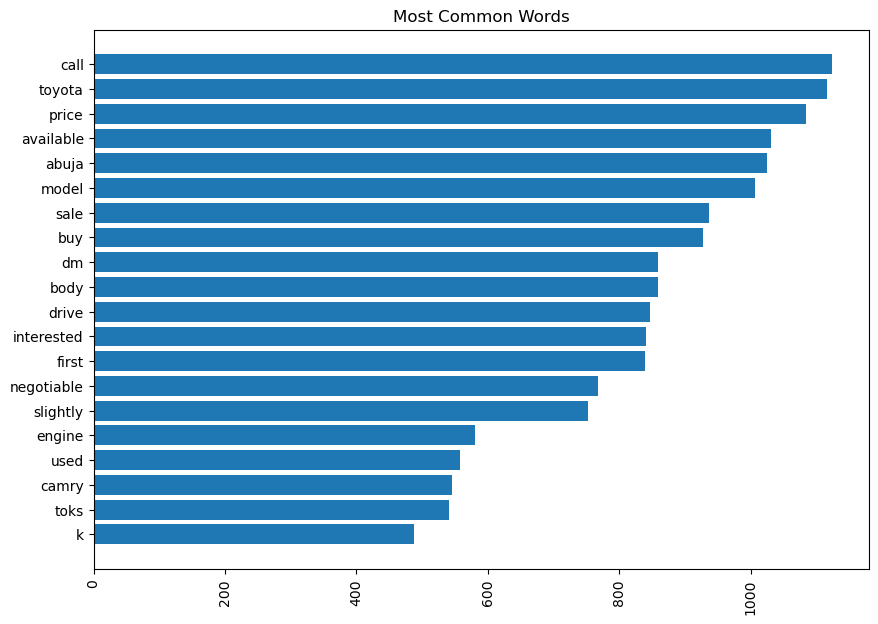

In [43]:
# Plot a graph of the most common words
plt.figure(figsize=(10, 7))
plt.barh(most_common[0], most_common[1])
plt.xticks(rotation="vertical")
plt.title("Most Common Words");

### Number of Emojis

In [44]:
# extract all the emojis in the "Message" column
emojis = []
for message in df["Message"]:
    emojis.extend([c for c in message if c in emoji.EMOJI_DATA.keys()])

    
# Create and emoji dataframe
emoji_df = pd.DataFrame(Counter(emojis).most_common())

emoji_df

,0,1
0,📞,220
1,🔛,124
2,💯,111
3,💦,88
4,🔥,76
...,...,...
87,🥵,1
88,👍,1
89,🆗,1
90,⛽,1


In [45]:
# rename column
emoji_df.columns = ["Emoji", "Count"]
emoji_df

,Emoji,Count
0,📞,220
1,🔛,124
2,💯,111
3,💦,88
4,🔥,76
...,...,...
87,🥵,1
88,👍,1
89,🆗,1
90,⛽,1


In [46]:
# Create a percentage usage column
emoji_count = list(emoji_df["Count"])
per_list = [(i/sum(emoji_count))*100 for i in emoji_count]
emoji_df["Percentage use"] = np.array(per_list).round(2)

emoji_df

,Emoji,Count,Percentage use
0,📞,220,18.23
1,🔛,124,10.27
2,💯,111,9.20
3,💦,88,7.29
4,🔥,76,6.30
...,...,...,...
87,🥵,1,0.08
88,👍,1,0.08
89,🆗,1,0.08
90,⛽,1,0.08


### Monthly Timeline 

We want the count of the messages per-month, therefore we will apply `.groupby()` method and adding `reset_index()` will get the result in a dataframe format.

We will then add the `Year` and `Month` columns to get as an example `"January-2018"`. This is to enhance our analysis.

In [47]:
# Get monthly timeline

monthly_df = df.groupby(["Year", "Month_num", "Month"]).count()["Message"].reset_index()
monthly_df

,Year,Month_num,Month,Message
0,2022,9,September,1
1,2023,1,January,36
2,2023,2,February,2508
3,2023,3,March,6706
4,2023,4,April,5977
5,2023,5,May,3607


In [48]:
monthly_timeline = []
for i in range(monthly_df.shape[0]):
    monthly_timeline.append(monthly_df["Month"][i]+"-"+str(monthly_df["Year"][i]))

monthly_df["monthly_timeline"] = monthly_timeline
monthly_df

,Year,Month_num,Month,Message,monthly_timeline
0,2022,9,September,1,September-2022
1,2023,1,January,36,January-2023
2,2023,2,February,2508,February-2023
3,2023,3,March,6706,March-2023
4,2023,4,April,5977,April-2023
5,2023,5,May,3607,May-2023


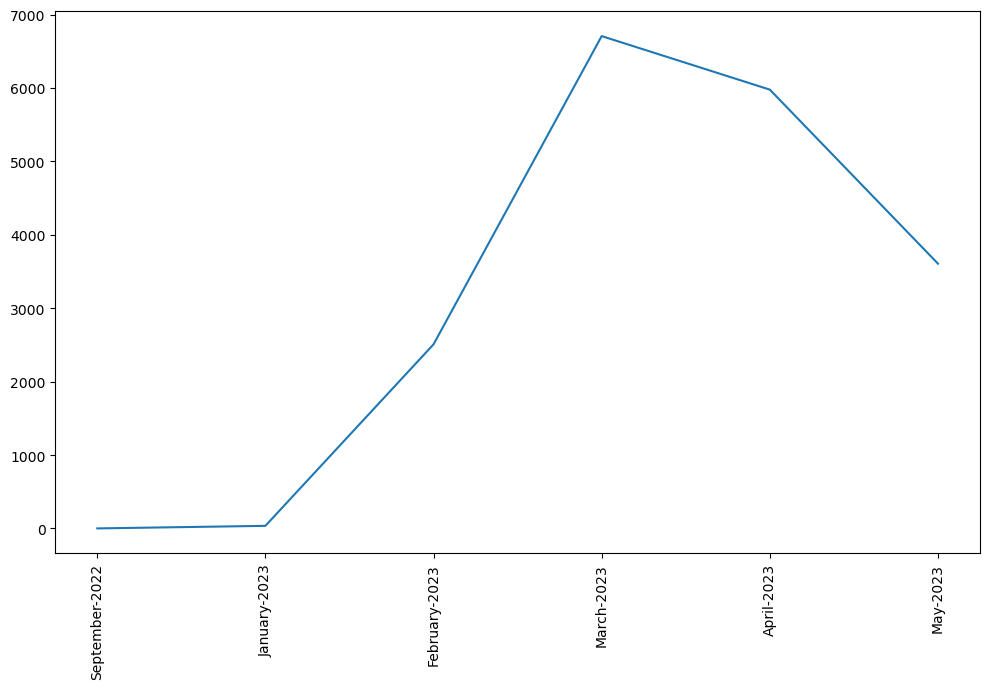

In [49]:
# Plot the monthy timeline of messages
plt.figure(figsize=(10, 7))
plt.plot(monthly_df["monthly_timeline"], monthly_df["Message"])
plt.xticks(rotation="vertical")
plt.tight_layout();

### Activity Map

**Most Active Days**

In [50]:
# Get a count of chats perday
active_days = df["Day_name"].value_counts()
active_days

Wednesday    3151
Thursday     3043
Monday       2942
Tuesday      2891
Saturday     2591
Friday       2340
Sunday       1877
Name: Day_name, dtype: int64

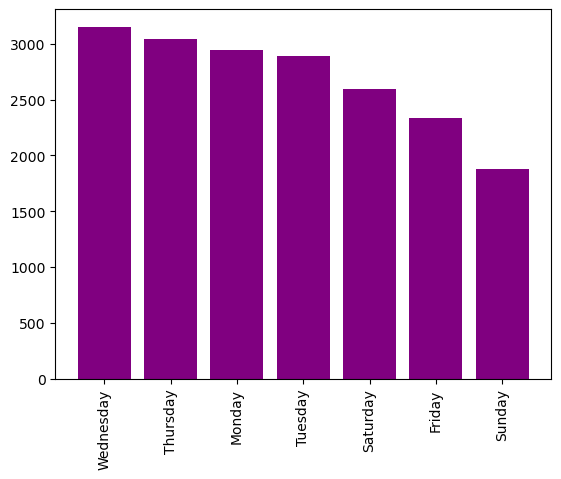

In [51]:
# Plot the graph of messages per day
plt.bar(active_days.index, active_days.values, color="purple")
plt.xticks(rotation="vertical");

**Most Active Months**

In [52]:
active_months = df["Month"].value_counts()
active_months

March        6706
April        5977
May          3607
February     2508
January        36
September       1
Name: Month, dtype: int64

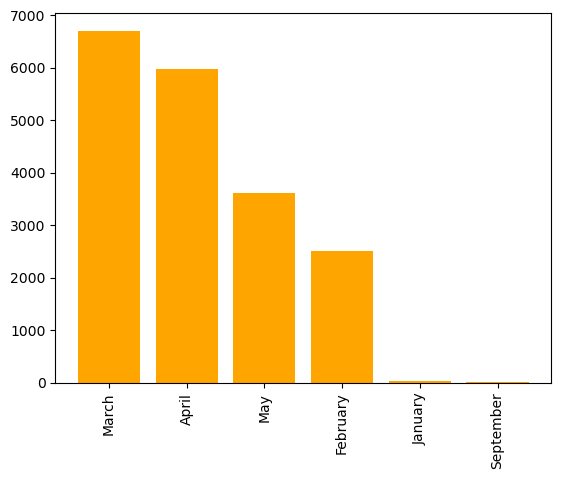

In [53]:
# plot a graph of the most active months
plt.bar(active_months.index, active_months.values, color="orange")
plt.xticks(rotation="vertical");